In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

In [3]:
tmp = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

median_rating = tmp['averageRating'].median()

In [4]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


tmp = tmp.sort_values(by='Movie release date')
tmp['ReleaseYearRange'] = tmp['Movie release date'].apply(lambda x: create_range(x))

In [5]:
display(tmp)

,,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,awards,nominations,movie_count,movie_count_genre,genres_b4,IsDrama,isMale,age_at_release,averageRating,ReleaseYearRange
IMDb_ID,IMDb_actor_ID,,,,,,,,,,,,,,,,
tt0021061,nm0642988,1,24383800,Let's Go Native,1930,Jack Oakie,1903,0,0,1,1,2,0,1,27,5.8,1930 - 1940
tt0021324,nm0000802,1,5884622,The Runaway Bride,1930,Mary Astor,1906,0,0,1,1,7,0,0,24,4.9,1930 - 1940
tt0021233,nm0823597,1,32828818,Pardon My Gun,1930,Sally Starr,1909,0,0,1,0,1,0,0,21,4.3,1930 - 1940
tt0020690,nm0002001,1,142837,The Big Pond,1930,Maurice Chevalier,1888,0,1,1,0,7,0,1,42,5.7,1930 - 1940
tt0020806,nm0938464,1,2134118,Danger Lights,1930,Louis Wolheim,1880,0,0,1,0,1,1,1,50,6.1,1930 - 1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2126282,nm3070408,1,31656709,Ekk Deewana Tha,2012,Prateik Patil Babbar,1986,0,0,1,1,6,1,<NA>,26,6.1,2010 - 2020
tt2351177,nm3054665,1,35279558,Bhooter Bhabishyat,2012,Swastika Mukherjee,1980,0,0,1,0,1,0,0,32,8.1,2010 - 2020
tt1623288,nm2240346,1,31804949,ParaNorman,2012,Kodi Smit-McPhee,1996,0,0,2,1,7,0,1,16,7.0,2010 - 2020


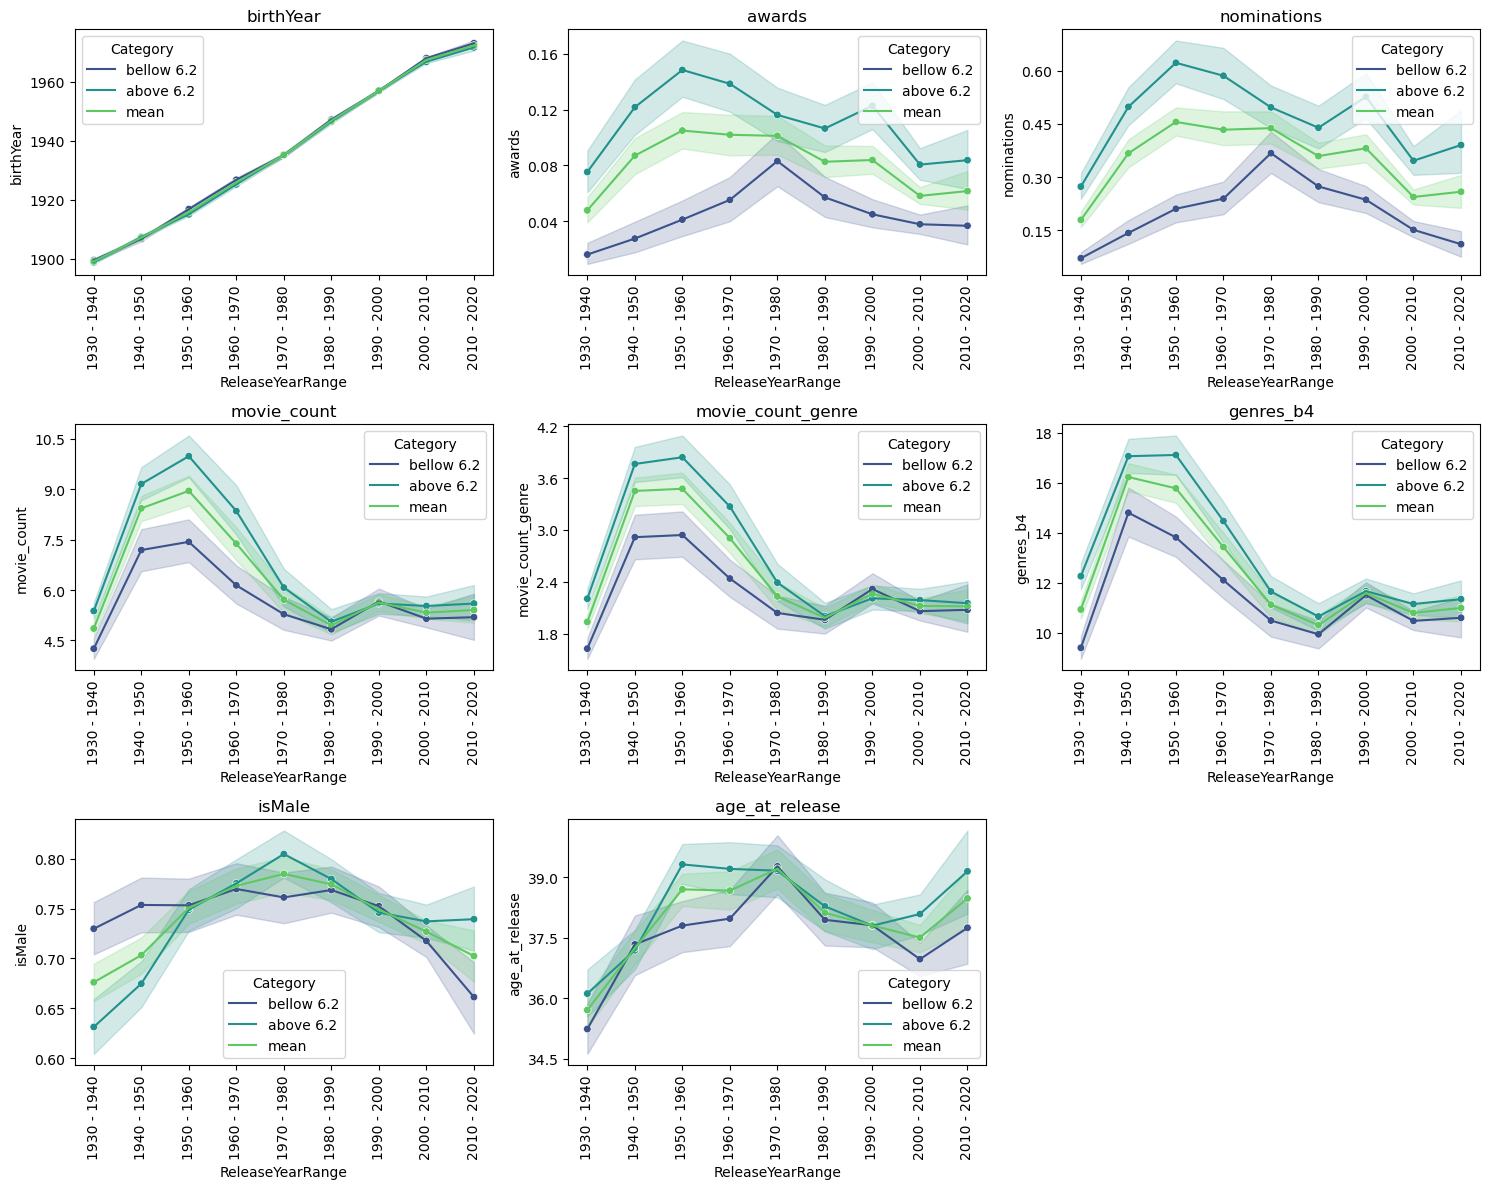

In [6]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    df = df.replace("\\N", pd.NA)

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        me_filtered_mean['Category'] = 'mean'

        frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

do_fancy_ecpi_cute_plot(tmp, 'median_rating', 'averageRating', 'ReleaseYearRange', 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'])

TODO: Add T-tests pour certains trucs par année, p.e en 1950-1960, p= 0.03 entre good grades et bad grades -> significant

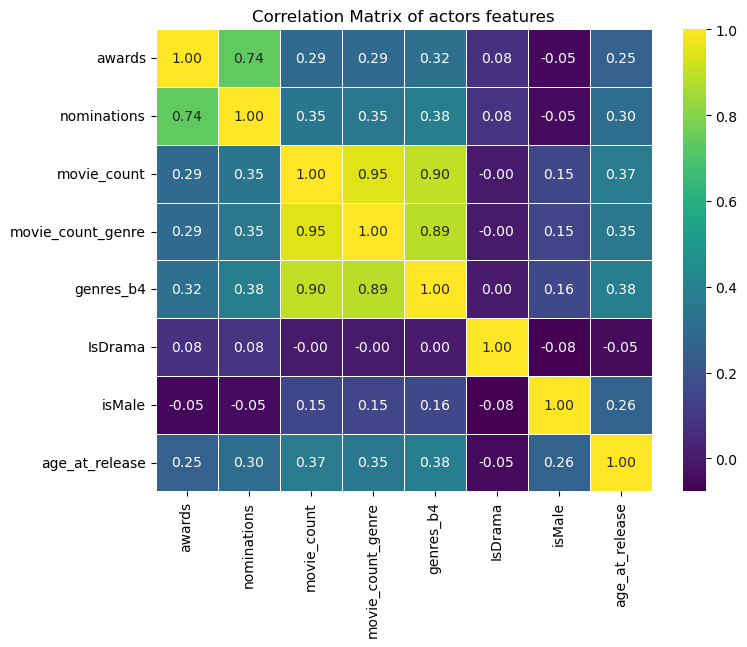

In [7]:
# Calculate the correlation matrix
correlation_matrix = actors['Features'].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

**High correlations**
- 0.95: Movie count vs Movie count in drama 
- 0.90: Movie count vs Genres diversity
- 0.89: Movie count in drama vs Genres diversity
- 0.74: Nominations vs Awards


# We saw from (Dimitri's) graphs, that the awards and nominations seemed to have a large influence on the average film raiting over all years. 
Lets have a look at the correlation

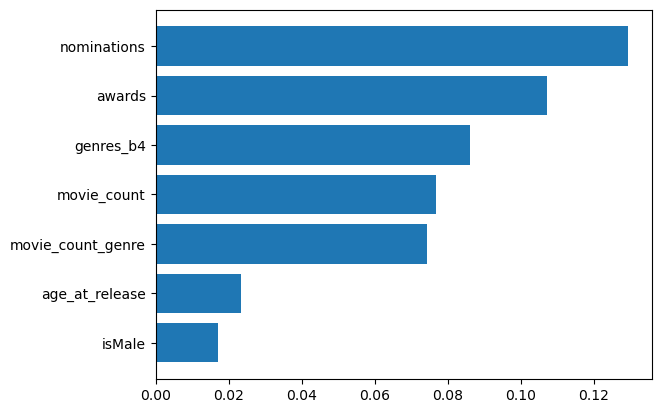

In [8]:
correlation_matrix=tmp[[ 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release','averageRating']].corr()
correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')  # Remove correlation with itself
correlation_with_X_sorted = correlation_with_X.sort_values()
# Create a horizontal bar plot
plt.barh(correlation_with_X_sorted.index, correlation_with_X_sorted)
plt.show()

<Axes: xlabel='awards', ylabel='averageRating'>

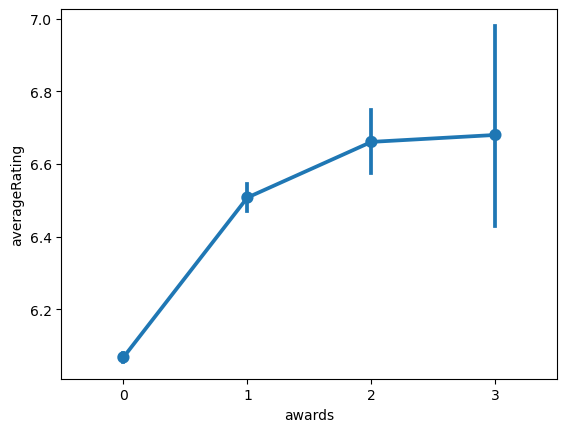

In [9]:
sns.pointplot(x='awards', y='averageRating', data=tmp, errorbar=('ci', 95))

Even though there is a large confidence interval the higher the award count is, we can conclude that actors with oscars do infact play in betrter films.

<Axes: xlabel='nominations', ylabel='averageRating'>

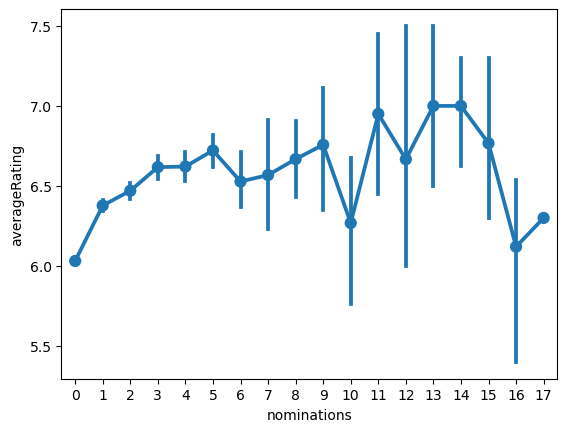

In [10]:
sns.pointplot(x='nominations', y='averageRating', data=tmp, errorbar=('ci', 95))

In [11]:
model = smf.glm(formula='averageRating ~ awards', data=tmp)
fit = model.fit()
print(fit.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                 Generalized Linear Model Regression Results                  
Dep. Variable:          averageRating   No. Observations:                28414
Model:                            GLM   Df Residuals:                    28412
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1244
Method:                          IRLS   Log-Likelihood:                -41983.
Date:                Sun, 17 Dec 2023   Deviance:                       31947.
Time:                        14:21:48   Pearson chi2:                 3.19e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01154
Covariance Type:            nonrobust  

In [12]:
tmp.reset_index(drop=True, inplace=True) #TODO Peut etre a changer

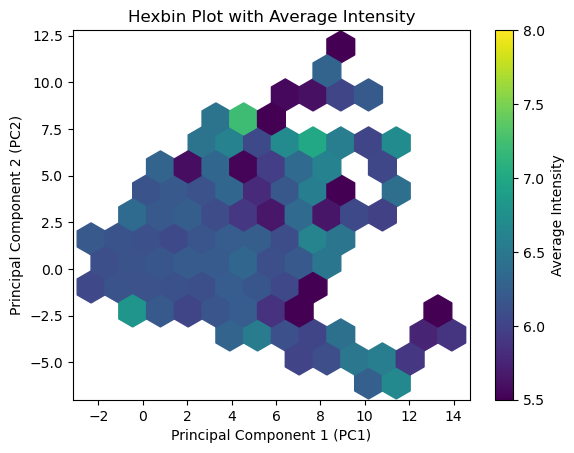

In [13]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(tmp[[ 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release','averageRating']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = tmp[['averageRating']]

# Set custom vmin and vmax values
vmin = 5.5  # minimum value for the color scale
vmax = 8  # maximum value for the color scale

# Create a hexbin plot with average intensity
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=13, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity')
plt.show()

We can see that the right is a bit lighter than the left meaning that there is a difference in actors between good and bad films
#todo -> Same but with hue(+6.2, -6.2)

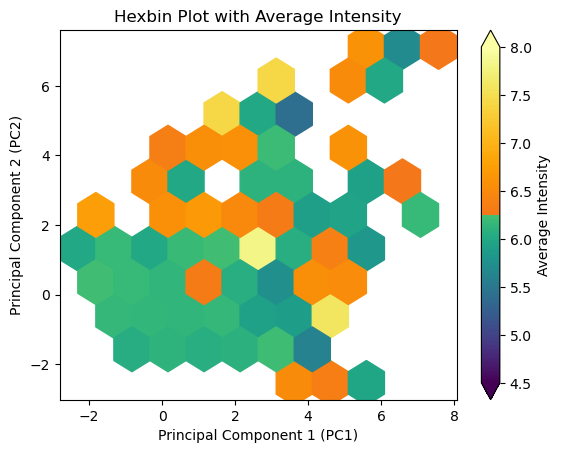

In [22]:
Years = tmp['ReleaseYearRange'].unique()
Year40 = tmp[tmp['ReleaseYearRange'] == '1940 - 1950']

scaler = StandardScaler()
df_standardized = scaler.fit_transform(Year40[['awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = tmp['averageRating']

# Set custom vmin and vmax values
vmin = 4.5  # minimum value for the color scale
vmax = 8    # maximum value for the color scale

# Create a custom colormap
colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)

# Create a hexbin plot with the custom colormap
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity', extend='both')  # Add extend='both' to show color limits beyond the data range
plt.show()

In [15]:
Years = tmp['ReleaseYearRange'].unique()
Year40 = tmp[tmp['ReleaseYearRange'] == '1950 - 1960']


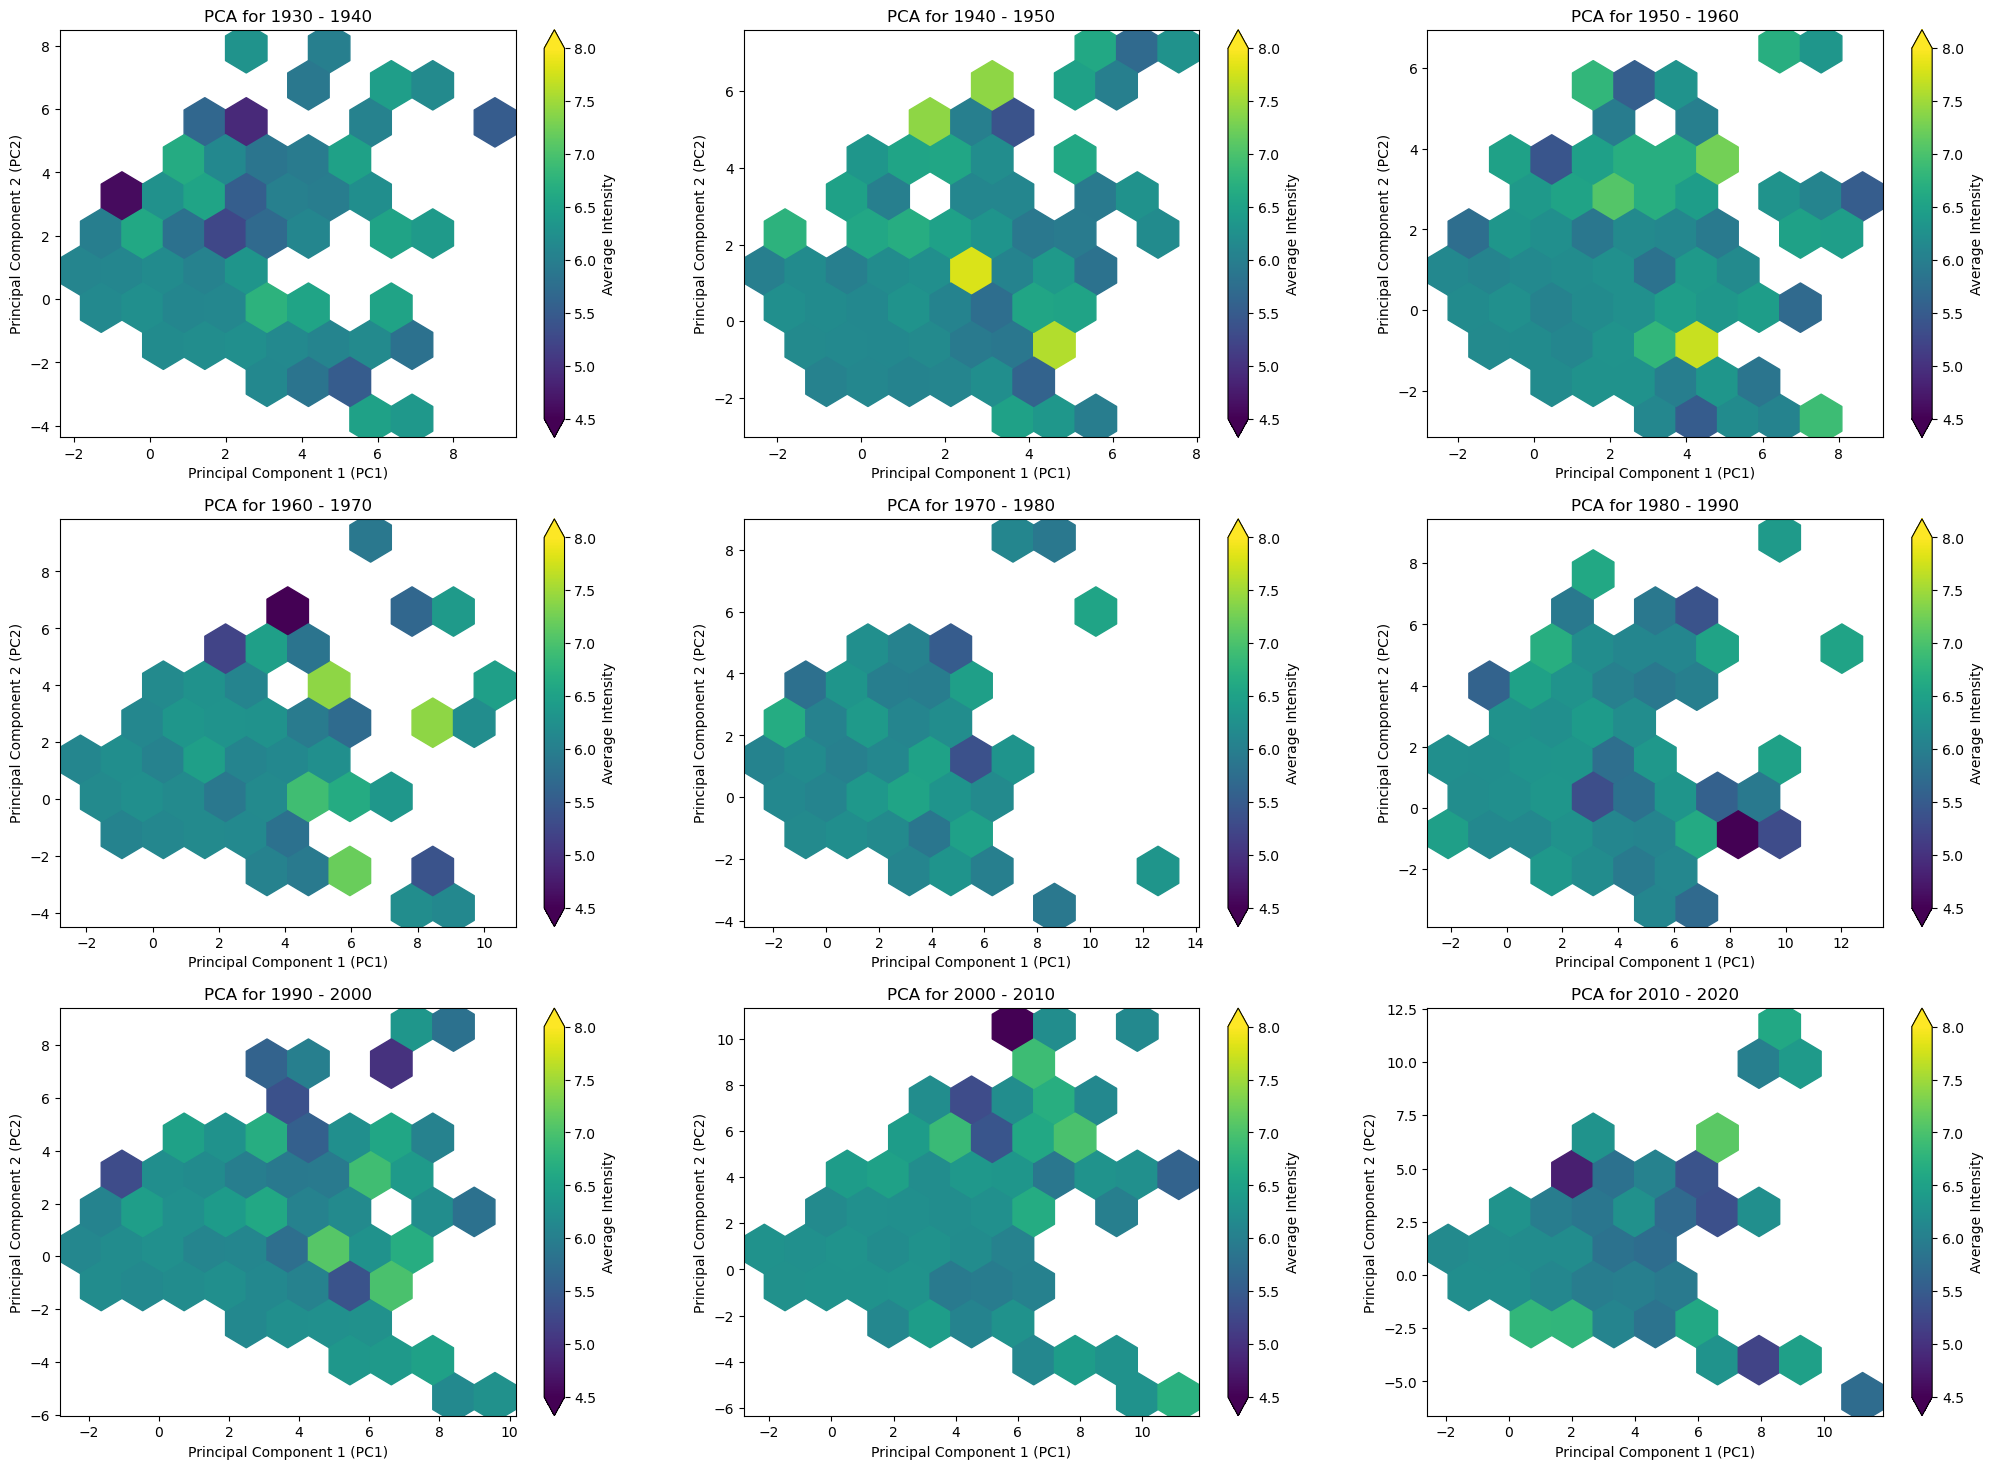

In [36]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = tmp['ReleaseYearRange'].unique()

for i, year_range in enumerate(Years):

    Year = tmp[tmp['ReleaseYearRange'] == Years[i]]
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(Year[['awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release']].dropna())
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)
    
    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_pca['Rating'] = tmp['averageRating']
    
    # Set custom vmin and vmax values
    vmin = 4.5  # minimum value for the color scale
    vmax = 8    # maximum value for the color scale
    
    # Create a custom colormap
    colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
    colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
    colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)
    
    # Create a hexbin plot with the custom colormap
    hexbin = axs[i].hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')
    plt.colorbar(hexbin, label='Average Intensity', extend='both')

    
plt.show()